In [ ]:
# !pip install mlxtend
# !pip install imblearn

In [190]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, roc_curve)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import copy
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [149]:
df = pd.read_csv('labelled_data_1.csv', index_col=False)
df.drop(columns=['Unnamed: 0.1', 'Column1', 'Unnamed: 0'], inplace=True)
df.head()

,start_dt,end_dt,sender_name,sender_email,theme,descr,sender_name_cut,texts_cmb,topic,cluster
0,01.01.2023 11:22,01.01.2023 22:14,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,. Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА...,content_problem,"['жалоба', 'абонент', 'просьба', 'ответ', 'зап...",9,2
1,01.01.2023 14:18,01.01.2023 22:18,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
2,01.01.2023 15:31,01.01.2023 21:52,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
3,01.01.2023 16:15,01.01.2023 21:51,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1
4,01.01.2023 16:15,01.01.2023 21:52,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! Абонент утверждает, что...",content_problem,"['жалоба', 'абонент', 'абонент', 'утверждать',...",5,1


In [124]:
df.cluster.value_counts(normalize=True)

cluster
1     0.405727
4     0.191519
9     0.118498
6     0.072228
5     0.048747
3     0.042406
10    0.036758
7     0.032993
8     0.032002
2     0.017042
?     0.002081
Name: proportion, dtype: float64

In [176]:
df.drop(df[df.cluster == '?'].index, inplace=True)

In [177]:
df['cluster'].notna().sum()

10072

In [178]:
df = df[df['cluster'].notna()]

Классы в датасете не сбалансированы. 

5 тема - 50% всего датасета.

1. Обращения
2. 
   1.1. Списания/денежные средства
   1.2. Проблемы с сим-меню
   1.3. Esim (проблемы подключения, код активации, qr-код)
   1.4. Проблемы с контентом и отключение услуг/ подписок/ сервисов
   1.5. Учетные записи
3. Информация
   1.6. Уведомления о технических работах
   1.7. Сбой работы (в работе оператора)
   1.8. Тесты, проблемы с доставкой, прочие тех. оповещения
4. Черный список
   1.9. Черный список
5. Спам
   1.10. Спам, реклама

In [131]:
# Вики статьи для тикетов тех поддержки
articles_df = pd.read_csv('articles.csv', index_col=False)
articles_df['topic_text'] = articles_df['topic'].astype(str) + articles_df['text'].astype(str) 

articles_df.head()

,topic,text,topic_text
0,Списание денежных средств,Абонент обращается с жалобой на некорректные с...,Списание денежных средствАбонент обращается с ...
1,Отключение SIM-меню\r,Эта статья описывает процедуру обработки жалоб...,Отключение SIM-меню\rЭта статья описывает проц...
2,Обращения ESIM,"Эта статья поможет вам решить проблемы, связан...",Обращения ESIMЭта статья поможет вам решить пр...
3,Проблемы с контентом и отключение услуг/ подпи...,Эта категория обращений связана с запросами аб...,Проблемы с контентом и отключение услуг/ подпи...
4,Учетные записи,В системе B2B используются учетные записи для ...,Учетные записиВ системе B2B используются учетн...


# Preprocess text

In [151]:
import pymorphy3
from nltk.corpus import stopwords
from collections import defaultdict
from tqdm import tqdm
import re
import nltk


class TextPreprocessor:
    def __init__(self):
        self.morph = pymorphy3.MorphAnalyzer()
        self.stopwords_set = set(stopwords.words('russian')) 
        self.stopwords_set.update(['который', 'всё', 'добрый', 'время', 'сутки', '--', '00мск'])
        self.morph_exceptions = {'сим'}
        self.manual_corrections = {
            'удали': 'удалить',
            'использьзовать': 'использовать',
            'теле': 'теле2'
        }
        self.phone_pattern = re.compile(r'^((8|\+7)[\- ]?)?(\(?\d{3}\)?[\- ]?)?[\d\- ]{7,10}$')
        self.name_pattern = re.compile(r'\b[А-ЯЁ][а-яё]+\s[А-ЯЁ][а-яё]+\b')
        self.sim_card_pattern = re.compile(r'\bсим-карт\w*\b')

    def clean_key(self, key):
        if isinstance(key, str):
            key = self.phone_pattern.sub('номер телефона', key)
            key = self.name_pattern.sub('фио', key)
            key = re.sub(r'(?<![\w])\d+(?![\w])', '', key)
            key = re.sub(r'[!?]', '.', key)
            key = re.sub(r'\s-\s', ' ', key)
            key = re.sub(r'(?<!\S)-|-(?!\S)', '', key)  
            return key
        else:
            return ''

    def split_key(self, key_mod):
        result = []
        temp_word = []
    
        for char in key_mod:
            if char.isalpha() or char.isdigit() or char == '-':
                temp_word.append(char)
            elif char == '.':
                if temp_word:
                    result.append(''.join(temp_word))
                    temp_word = []
                result.append('.')
            elif char.isspace():
                if temp_word:
                    result.append(''.join(temp_word))
                    temp_word = []
    
        if temp_word:
            result.append(''.join(temp_word))
    
        return result

    def clean_punctuation(self, list_elements):
        return [element for element in list_elements if element != '.']

    def preprocess_text(self, text):
        cleaned_list = []
        key_mod = self.clean_key(text)
        words = self.split_key(key_mod.lower())

        for token in words:
            # if token == '.':
            #     cleaned_list.append(token)
            # else:
                if self.sim_card_pattern.search(token):
                    token = self.sim_card_pattern.sub('сим-карта', token)

                token = self.manual_corrections.get(token, token)

                if token not in self.morph_exceptions:
                    normal_form = self.morph.parse(token)[0].normal_form
                else:
                    normal_form = token

                if normal_form not in self.stopwords_set and normal_form != '.':
                    cleaned_list.append(normal_form)

        return cleaned_list




In [54]:
text = """
Доброе время суток! ПРОСЬБА ПРИ ОТВЕТЕ НА ЗАПРОС ИСПОЛЬЗЬЗОВАТЬ ФУНКЦИЮ "ОТВЕТИТЬ ВСЕМ" У абонента всплывает SIM-меню и блокирует работу телефона. Просьба отключить функционал сим-ремандера на апплете сим-карты. 
0. Номер абонента : 79629002669 
1. Дата и время заказа : 31,12,2022 
2. Номер провайдера (для КЦ из InVoice / для розницы - номер подписки из WD) : - 
3. Описание проблемы : не отключается теле 2 меню 
4. Текст сообщения на эк.

"""

preprocessor = TextPreprocessor()
processed_text = preprocessor.preprocess_text(text)
print(processed_text)

['просьба', 'ответ', 'запрос', 'использовать', 'функция', 'ответить', 'весь', 'абонент', 'всплывать', 'sim-меню', 'блокировать', 'работа', 'телефон', 'просьба', 'отключить', 'функционал', 'сим-ремандёра', 'апплет', 'сим-карта', 'номер', 'абонент', 'дата', 'заказ', 'номер', 'провайдер', 'кц', 'invoice', 'розница', 'номер', 'подписка', 'wd', 'описание', 'проблема', 'отключаться', 'теле2', 'меню', 'текст', 'сообщение', 'эк']


In [168]:
preprocessor = TextPreprocessor()
for index, text in enumerate(df['texts_cmb']):
    row = preprocessor.preprocess_text(text)
    df.at[index, 'texts_cmb'] = ' '.join(row)

In [166]:
for index, text in enumerate(articles_df['topic_text']):
    row = preprocessor.preprocess_text(text)
    articles_df.at[index, 'texts_cmb'] = ' '.join(row)

In [153]:
preprocessor = TextPreprocessor()
new_df = pd.DataFrame(columns=['preprocessed_text'])

data = [*df['descr'], *articles_df['topic_text']]

for index, text in enumerate(data):
    row = preprocessor.preprocess_text(text)
    new_df.at[index, 'preprocessed_text'] = row

In [154]:
preprocessed_text = []

for row in new_df['preprocessed_text']:
    preprocessed_text.append(row)

In [155]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(vector_size=100, window=5, min_count=1, sg=0, epochs=10)

w2v_model.build_vocab(preprocessed_text)
w2v_model.train(new_df['preprocessed_text'], total_examples=len(new_df['preprocessed_text']), epochs=model.epochs)


similarity = w2v_model.wv.similarity('ответ', 'запрос')
print(f"Сходство между 'ответ' и 'запрос': {similarity}")

Сходство между 'ответ' и 'запрос': 0.4422121047973633


In [156]:
w2v_model.wv.most_similar('список', topn=5)

[('внести', 0.6795409917831421),
 ('tele2-тема', 0.6454945802688599),
 ('push-уведомление', 0.6222384572029114),
 ('весь', 0.6056075692176819),
 ('ннажимать', 0.5958287119865417)]

In [158]:
# w2v_model.save("word2vec.model")

# Word2Vec

In [170]:
w2v_model = gensim.models.Word2Vec.load("word2vec.model")

df.texts_cmb = df.texts_cmb.astype(str)
texts_tokenized = [text.split() for text in df['texts_cmb']]

In [171]:
def get_mean_vector(text):
    words = [w for w in text if w in w2v_model.wv]
    return np.mean(w2v_model.wv[words], axis=0) if words else np.zeros(w2v_model.vector_size)

df['mean_vector'] = df['texts_cmb'].apply(lambda x: get_mean_vector(x))

In [173]:
articles_df['mean_vector'] = articles_df['texts_cmb'].apply(lambda x: get_mean_vector(x))

## SVM

In [179]:
X = np.array([get_mean_vector(text) for text in df['texts_cmb']])
y = df['cluster'].astype('int')

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [181]:
# Посмотрим на рапределение классов в тесте и трейне
print('y_train', y_train.value_counts(normalize=True))
print('y_test', y_test.value_counts(normalize=True))

y_train cluster
1     0.408658
4     0.182685
9     0.118745
6     0.081414
5     0.051628
3     0.046863
10    0.034948
7     0.030977
8     0.028594
2     0.015488
Name: proportion, dtype: float64
y_test cluster
1     0.405878
4     0.194996
9     0.118745
6     0.069367
5     0.047922
3     0.041038
10    0.037464
7     0.033757
8     0.033227
2     0.017607
Name: proportion, dtype: float64


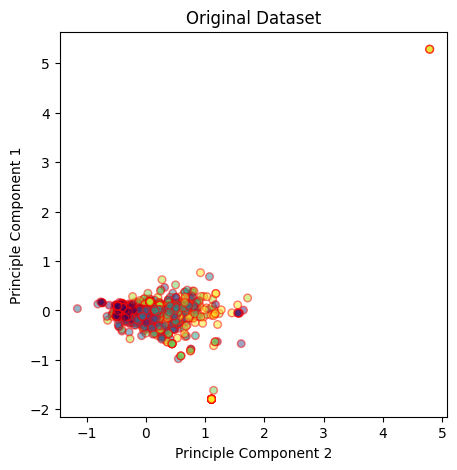

In [182]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(1, 0, 0, 0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

In [189]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel type
    'gamma': ['scale', 'auto', 0.1, 1, 10], # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'decision_function_shape':['ovr']
}

svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'decision_function_shape': 'ovr', 'gamma': 1, 'kernel': 'poly'}
Best Score: 0.8757045031398908


In [194]:
# Создаем модель SVM для многоклассовой классификации
svm_model = SVC(kernel='poly', decision_function_shape='ovr', gamma=1)

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred))

Точность классификации: 0.8786

Отчет о классификации:
               precision    recall  f1-score   support

           1       0.99      0.98      0.98      3066
           2       0.64      0.73      0.68       133
           3       0.75      0.74      0.75       310
           4       0.77      0.88      0.82      1473
           5       0.86      0.83      0.85       362
           6       0.94      0.93      0.93       524
           7       0.73      0.80      0.76       255
           8       0.67      0.48      0.56       251
           9       0.90      0.88      0.89       897
          10       0.66      0.42      0.52       283

    accuracy                           0.88      7554
   macro avg       0.79      0.77      0.77      7554
weighted avg       0.88      0.88      0.88      7554



### Random Oversampling

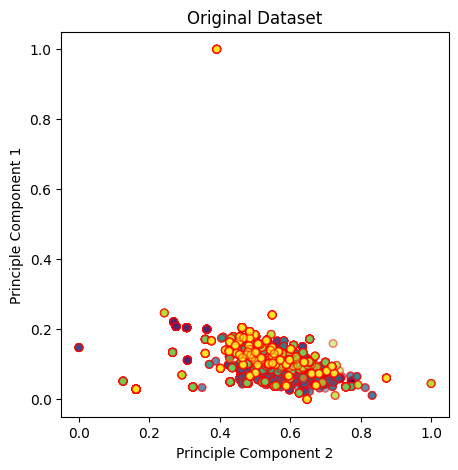

In [195]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_ros, y_train_ros, ax, title='Original Dataset')

In [203]:
# Train SVC on randomly oversampled data
clf_ros = SVC(kernel='poly', decision_function_shape='ovr', gamma=1)
clf_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = clf_ros.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_ros)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_ros))

Точность классификации: 0.8786

Отчет о классификации:
               precision    recall  f1-score   support

           1       0.98      0.98      0.98      3066
           2       0.52      0.81      0.63       133
           3       0.58      0.84      0.69       310
           4       0.86      0.77      0.81      1473
           5       0.84      0.83      0.84       362
           6       0.94      0.91      0.93       524
           7       0.80      0.86      0.83       255
           8       0.72      0.86      0.79       251
           9       0.91      0.88      0.90       897
          10       0.61      0.52      0.56       283

    accuracy                           0.88      7554
   macro avg       0.78      0.83      0.79      7554
weighted avg       0.89      0.88      0.88      7554



## Undersampling

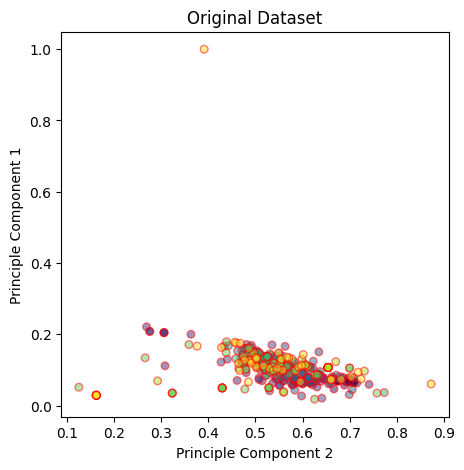

In [198]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_rus, y_train_rus, ax, title='Original Dataset')

In [200]:
# Train SVC on randomly undersampled data
clf_rus = SVC(kernel='poly', decision_function_shape='ovr', gamma=1)
clf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = clf_rus.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8054

Отчет о классификации:
               precision    recall  f1-score   support

           1       0.96      0.97      0.96      3066
           2       0.43      0.83      0.56       133
           3       0.41      0.77      0.54       310
           4       0.80      0.50      0.61      1473
           5       0.78      0.79      0.78       362
           6       0.94      0.90      0.92       524
           7       0.48      0.82      0.61       255
           8       0.65      0.60      0.62       251
           9       0.88      0.85      0.86       897
          10       0.52      0.53      0.52       283

    accuracy                           0.81      7554
   macro avg       0.68      0.75      0.70      7554
weighted avg       0.83      0.81      0.81      7554



## Class weights


In [201]:
# Train SVC on default data
clf_bal = SVC(kernel='poly', decision_function_shape='ovr', gamma=1, class_weight='balanced')
clf_bal.fit(X_train, y_train)
y_pred_rus = clf_bal.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rus)
print(f"Точность классификации: {accuracy:.4f}")
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred_rus))

Точность классификации: 0.8643

Отчет о классификации:
               precision    recall  f1-score   support

           1       0.98      0.97      0.98      3066
           2       0.50      0.79      0.61       133
           3       0.63      0.84      0.72       310
           4       0.85      0.69      0.76      1473
           5       0.85      0.83      0.84       362
           6       0.95      0.92      0.94       524
           7       0.60      0.88      0.72       255
           8       0.67      0.88      0.76       251
           9       0.91      0.87      0.89       897
          10       0.55      0.53      0.54       283

    accuracy                           0.86      7554
   macro avg       0.75      0.82      0.78      7554
weighted avg       0.88      0.86      0.87      7554



Анализ результатов SVM модели для многоклассовой классификации

Общая точность 0.8786:

1. Классы с высокой точностью:
Класс 1:
Precision = 0.99, Recall = 0.98, F1-score = 0.98.
Модель практически всегда правильно классифицирует примеры этого класса.
Этот класс содержит наибольшее количество тикетов, что может объяснять высокую точность.
Классы 6 и 9:
Класс 6: Precision = 0.94, Recall = 0.93, F1-score = 0.93.
Класс 9: Precision = 0.90, Recall = 0.88, F1-score = 0.89.
Оба класса имеют хорошие результаты, что указывает на уверенную работу модели.

2. Классы со средней точностью:
Класс 4:
Precision = 0.77, Recall = 0.88, F1-score = 0.82.
Несмотря на не самый высокий precision, модель хорошо классифиирует этого класса.
Класс 5:
Precision = 0.86, Recall = 0.83, F1-score = 0.85.
Средняя точность, но приемлемые результаты.
Класс 3:
Precision = 0.75, Recall = 0.74, F1-score = 0.75.
Значения сбалансированы, хотя точность и полнота могли бы быть выше.

3. Классы с низкой точностью:
Класс 8:
Precision = 0.67, Recall = 0.48, F1-score = 0.56.
Низкий recall (0.48) говорит о том, что модель пропускает значительное количество примеров этого класса.
Возможно, проблема связана с малым количеством данных или схожестью признаков с другими классами.
Класс 10:
Precision = 0.66, Recall = 0.42, F1-score = 0.52.
Очень низкий recall, так что модель плохо классифицирует этот класс.
Класс 2:
Precision = 0.64, Recall = 0.73, F1-score = 0.68.
Сравнительно низкая точность, хотя recall выше.

Общие выводы:
Дисбаланс классов:
Класс 1 содержит 40% тикетов, а некоторые другие классы, например, классы 2 (133) и 10 (283), содержат значительно меньше данных.

Такой дисбаланс влияет на производительность модели, так как алгоритм SVM часто уделяет больше внимания более частым классам.

Причины могут включать:
- Плохое разделение признаков между этими классами и другими.
- Малое количество данных в этих классах.

Macro average: Precision = 0.79, Recall = 0.77, F1-score = 0.77.
Эти значения усредняют метрики по всем классам и показывают, что модель работает не идеально для редких классов.
Weighted average: Precision = 0.88, Recall = 0.88, F1-score = 0.88.
Взвешенные значения выше из-за большого количества примеров класса 1.


Таким образом, модель показывает хорошую производительность в целом, но требует доработки для редких классов (особенно классы 8 и 10). Использование взвешенных весов классов и оптимизация параметров поможет улучшить результаты.